In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc3 as pm
import arviz as az

sns.set_style("whitegrid")

## Иерархическая линейная регрессия

Применим концепцию иерархических моделей к линейной регрессии. Такой подход позволяет моделям выполнять статистические выводы на уровне групп, а оценки вычислять на более высоком уровне. Как уже было сказано ранее, это осуществляется с помощью введения априорных гиперраспределений.

Создадим восемь взаимосвязанных групп данных, включая одну группу с единственной точкой данных:

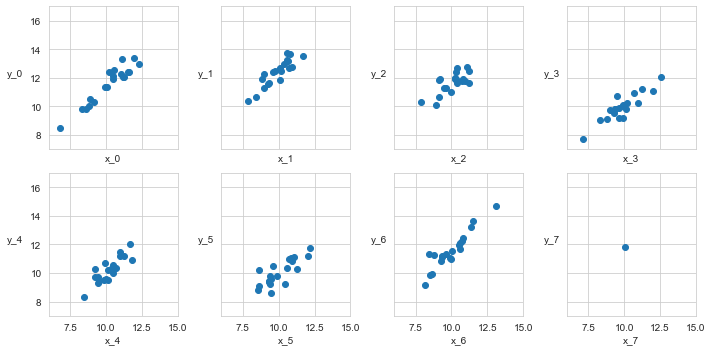

In [2]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

Центрируем данные для облегчения работы сэмплера и выполним подгонку  <b>неиерархической</b> модели.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ν, ε, β, α_tmp]
Sampling 3 chains, 2 divergences: 100%|██████████| 7500/7500 [00:04<00:00, 1741.77draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


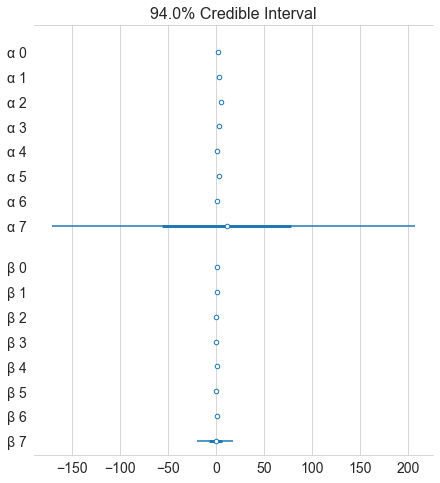

In [3]:
x_centered = x_m - x_m.mean()

with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ε, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    trace_up = pm.sample(2000)
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True);

Очевидно, что оценки параметров $\alpha_7$ и $\beta_7$ находятся в чрезвычайно широком интервале по сравнению с остальными параметрами 
$\alpha_{0-6}$ и $\beta_{0-6}$.

Это происходит, так как необходимы, по меньшей мере, две точки, иначе параметры $\alpha$  и $\beta$ становятся неограниченными. Это действительно так, если только не будет предоставлена некоторая дополнительная информация, например с использованием априорных распределений. Назначение строго определенного априорного распределения
для $\alpha$ может привести к генерации четко определенного набора линий даже для одной точки данных. 

Другой способ передачи информации – определение иерархических моделей, поскольку они позволяют совместно использовать информацию нескольким группам, редуцируя правдоподобные значения оцениваемых параметров. Это становится весьма полезным в тех случаях, когда имеются группы с разреженными (разбросанными) данными. В рассматриваемом примере разреженность данных была доведена до предела - одна из групп содержала единственную точку данных.

Теперь выполним реализацию иерархической модели, которая представляет собой ту же обычную модель линейной регрессии, но с априорными гиперраспределениями, которые можно наглядно изобразить на следующей диаграмме:
 ![](02-IerLinModel.png)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ν, ε, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 3 chains, 529 divergences: 100%|██████████| 12000/12000 [00:11<00:00, 1081.41draws/s]
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 316 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6567033373295188, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


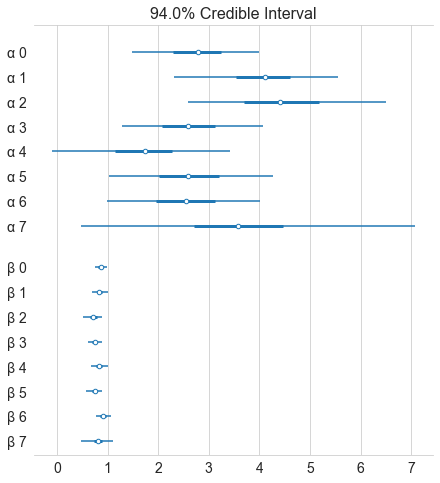

In [4]:
with pm.Model() as hierarchical_model:
    # априорные гипер-распределения
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sd=10)
    β_μ = pm.Normal('β_μ', mu=0, sd=1)
    β_σ = pm.HalfNormal('β_σ', sd=1)

    # априорные распеределения
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 5)   
    ν = pm.Exponential('ν', 1/30)
    
    # апосториорное распределение
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ε, nu=ν, observed=y_m)
    
    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    # трассировка
    trace_hm = pm.sample(3000, tune=1000)

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

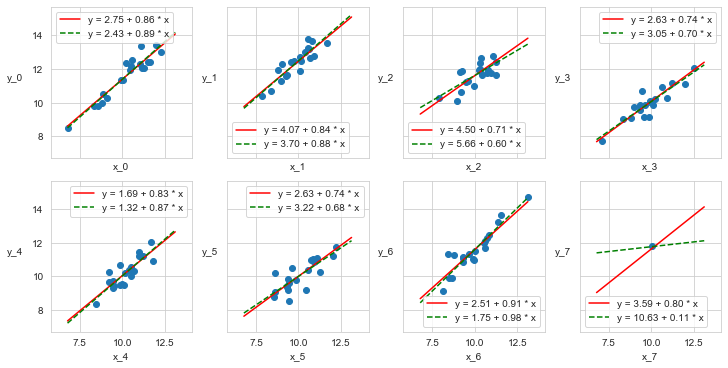

In [5]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    alpha_o = trace_up['α'][:, i].mean()
    beta_o = trace_up['β'][:, i].mean()
    ax[i].plot(x_range, alpha_o + beta_o * x_range, 'g--',
               label=f'y = {alpha_o:.2f} + {beta_o:.2f} * x')
    
    ax[i].legend()
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
    

Повторим еще раз, это является прямым следствием применения структуры иерархической модели, каждая линия получает информацию от линий других групп, таким образом, в действительности подгонка линии выполняется не по единственной точке. 

## Полиномиальная регрессия

Приведем построение полиномиальной регрессии, только в качестве примера. Позднее мы обсудим линейные и полиномиальные регрессии в теме сравнение "моделей"

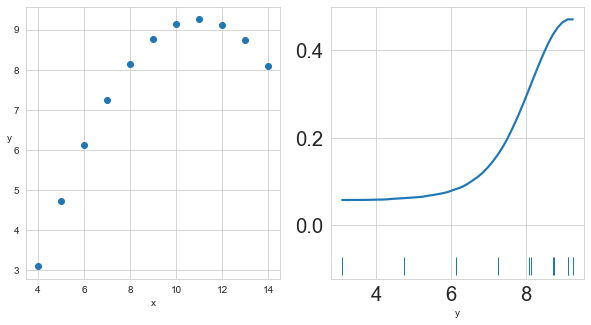

In [6]:
df = sns.load_dataset("anscombe")
x = df[df.dataset=="II"].x.values
y = df[df.dataset=="II"].y.values

_, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(x, y, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)

az.plot_kde(y, ax=ax[1], rug=True)
ax[1].set_xlabel('y');

In [7]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y.mean(), sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ε = pm.HalfCauchy('ε', 5)

    mu = α + β1 * x + β2 * x**2

    y_pred = pm.Normal('y_pred', mu=mu, sd=ε, observed=y)

    trace_poly = pm.sample(1000) # target_accept=0.99 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ε, β2, β1, α]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:13<00:00, 321.58draws/s]
The acceptance probability does not match the target. It is 0.9342469864996331, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.936005753687688, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9814910333128108, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


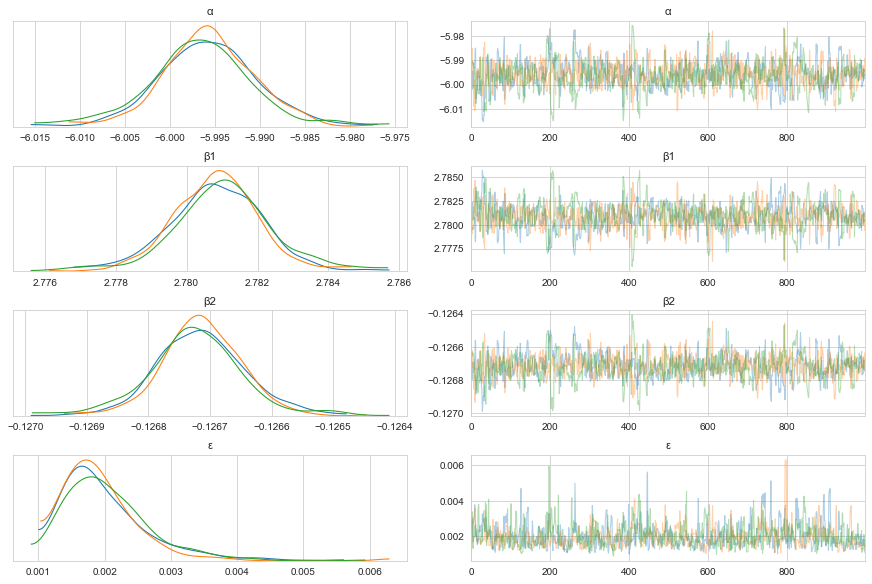

In [8]:
az.plot_trace(trace_poly);

In [9]:
az.summary(trace_poly)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-5.996,0.006,-6.007,-5.985,0.0,0.0,663.0,663.0,676.0,683.0,1.01
β1,2.781,0.001,2.778,2.784,0.0,0.0,663.0,663.0,682.0,675.0,1.01
β2,-0.127,0.000,-0.127,-0.127,0.0,0.0,685.0,685.0,706.0,693.0,1.01
ε,0.002,0.001,0.001,0.003,0.0,0.0,484.0,484.0,490.0,1024.0,1.01


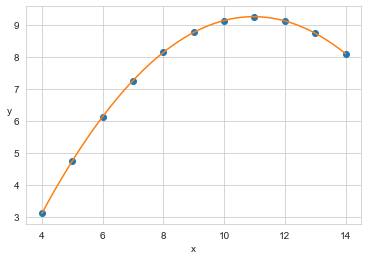

In [10]:
x_p = np.linspace(4, 14)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')